# Scalability

The solution and estimation of finite-horizon discrete choice dynamic programming model appears straightforward. However, it entails a considerable computational burden due to the well known curse of dimensionality (Bellman and Dreyfus, 1962). The figure below illustrates how the total number of states increases exponentially with each period. The size of the state space is shown for Keane and Wolpin (1994) (all models have the same state space) and the base and extended model of Keane and Wolpin (1997). The latter two models are different because the state space of the base parameterization does not include information on the previous activity which significantly reduces the complexity of the model. Note that the y-axis us log-scaled.

In [1]:
%matplotlib agg
import datetime as dt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import warnings


from matplotlib.ticker import FuncFormatter
from respy import get_example_model
from respy.python.solve.solve_auxiliary import pyth_create_state_space

warnings.filterwarnings("ignore", "This figure includes Axes that are not compatible")

In [2]:
plt.style.use("../_static/respy.mplstyle")

In [3]:
def _get_states_per_period(model):
    params, options, _ = rp.get_example_model(model)

    # This is not the official API, but we do only need the state space.
    state_space = rp.state_space.StateSpace(params, options)

    states_per_period = [
        len(range(slice_.start, slice_.stop))
        for slice_ in state_space.slices_by_periods
    ]

    return states_per_period

In [ ]:
models = ["kw_94_one", "kw_97_base", "kw_97_extended"]

container = {}

for model in models:
    container[model] = _get_states_per_period(model)

In [ ]:
fig, ax = plt.subplots()

for model, states_per_period in container.items():
    ax.semilogy(range(0, len(states_per_period)), states_per_period, label=model)

ax.set_xlabel("Period")
ax.set_ylabel("Number of states")

ax.legend([
    "Keane and Wolpin (1994)",
    "Keane and Wolpin (1997) - Base",
    "Keane and Wolpin (1997) - Extended"
])

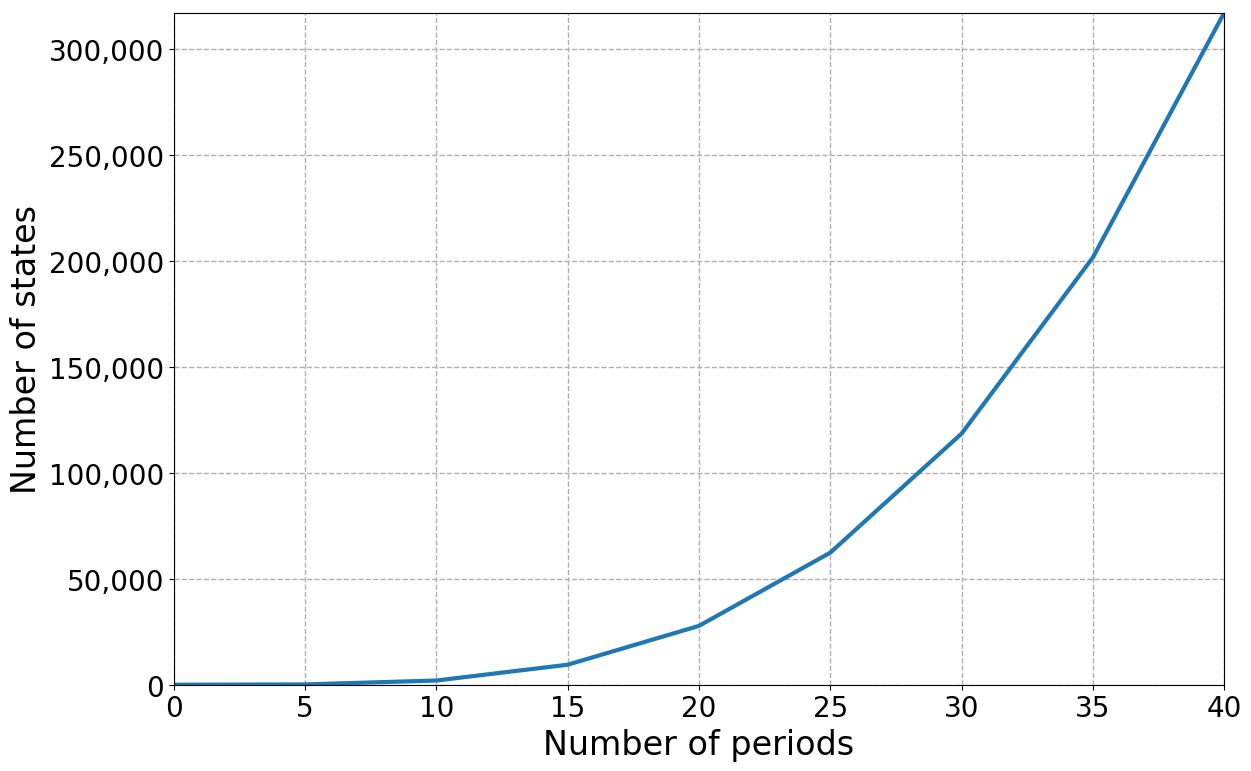

In [4]:
fig

During an estimation, thousands of different candidate parameterizations of the model are appraised with respect to the sample likelihood. Each time we need to evaluate the four-dimensional integral of $E\max$ at a total of 163,410 states. Thus, in addition to Python, we also maintain a scalar and parallel Fortran implementation. We parallelize the workload using the master-slave paradigm. We assign each slave a subset of states to evaluate the $E\max$ and a subset of agents to simulate their choice probabilities. Below, we show the total computation time required for 1,000 evaluations of the criterion function as we increase the number of slave processors to ten. Judging against the linear benchmark, the code scales well over this range.

In [5]:
def string_to_seconds(x):
    x = x.split(":")
    return dt.timedelta(
        hours=int(x[0]), minutes=int(x[1]), seconds=float(x[2])
    ).total_seconds()


fortran = [
    "0:02:16.848518", "0:01:47.276747", "0:01:30.499044",
    "0:01:27.542854", "0:01:24.448538", "0:01:21.705801"
]
fortran = np.array([string_to_seconds(i) for i in fortran]) * 100

python = [
    "0:03:05.479473", "0:01:43.033041", "0:01:02.278314",
    "0:00:50.597641", "0:00:58.866487", "0:00:52.974376",
]
python = np.array([string_to_seconds(i) for i in python]) * 10

cores = np.array([1, 2, 4, 6, 8, 10])

fortran_benchmark = np.append(fortran[0], fortran[:-1] * cores[:-1] / cores[1:])
python_benchmark = np.append(python[0], python[:-1] * cores[:-1] / cores[1:])

fig, ax = plt.subplots()

ax.plot(cores, fortran, label="Fortran")
# ax.plot(cores, fortran_benchmark, c="C0", ls="--")

ax.plot(cores, python, label="Python", c="C1")
# ax.plot(cores, python_benchmark, c="C1", ls="--")

ax.set_xticks([1, 2, 4, 6, 8, 10])
ax.set_yticks([i * 900 for i in range(17)])
ax.set_yticklabels(range(0, 256, 15))

ax.set_xlim(1, 10)

ax.grid(True, which="major", axis="both", ls="--")

ax.set_xlabel("Number of threads")
ax.set_ylabel("Elapsed time (in minutes)")

# handles, labels = ax.get_legend_handles_labels()
# handles.append(mlines.Line2D([], [], ls="--", c="grey"))
# labels.append("Linear Benchmark")
# ax.legend(handles=handles, labels=labels);

ax.legend();

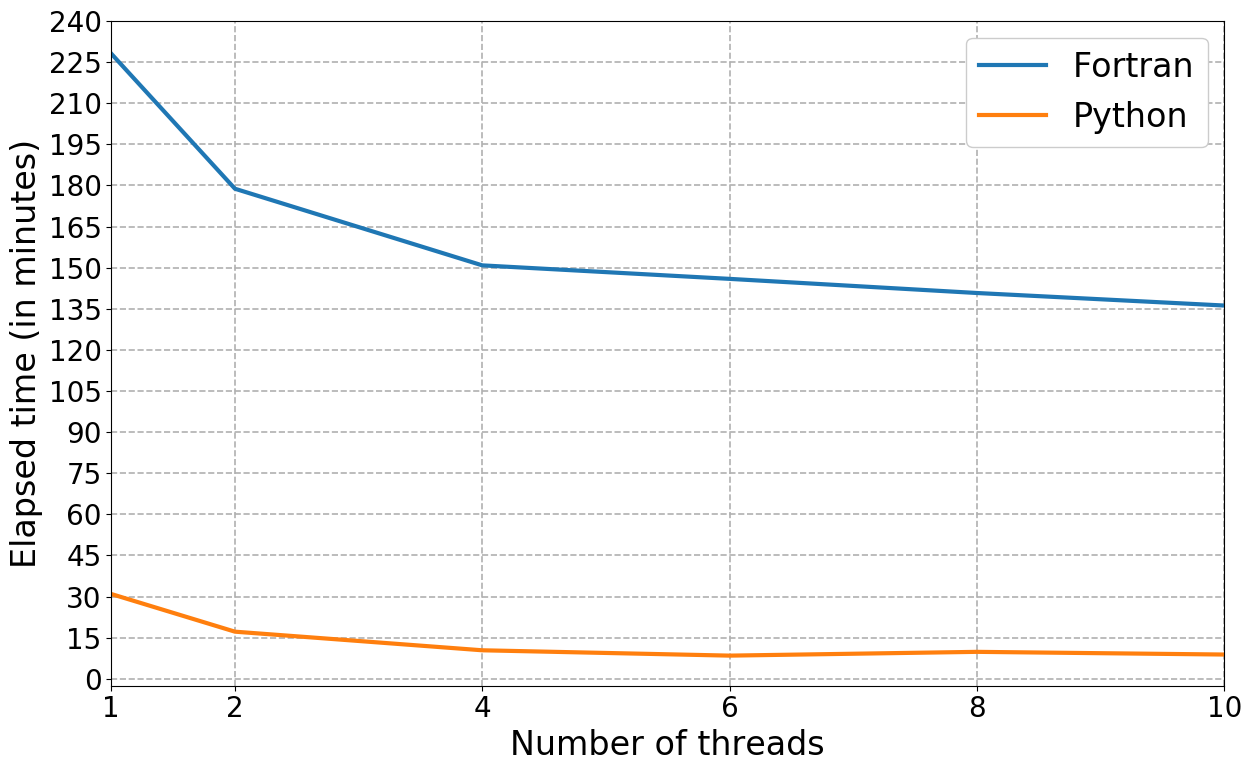

In [6]:
fig

Adding even more processors, however, does not lead to any further improvements, it even increases the computational time. The main reason is the time spend on the synchronization of $E\max$ across all processes each period. Even though each slave is only working on a subset of states each period, they need to access all previous $E\max$ results during the backward induction procedure.

For more details, see the script [online](https://github.com/OpenSourceEconomics/respy/blob/master/development/documentation/scalability/scalability_setup.py) and the [logfile](https://github.com/OpenSourceEconomics/respy/blob/master/docs/results/scalability.respy.info).
